In [1]:
import warnings
warnings.filterwarnings("ignore")

### LIBRARIES

In [30]:
# General imports
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import statistics
from scipy.stats import wilcoxon

# Data splitting and model evaluation
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    cross_val_predict,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV
)

# Performance metrics
from sklearn.metrics import (
    make_scorer,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    make_scorer, 
    recall_score,
    accuracy_score
)

# Model imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Imbalanced dataset handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline


### MODEL DEVELOPMENT

### Can perceived health be accurately predicted using dietary habits, socioeconomic indicators, lifestyle choices, and individual metrics?

In [3]:
%matplotlib inline

In [4]:
#Read in cleaned 2019 and 2021 Dataframes with numerical outliers removed
model_train = pd.read_csv('mydata/MMSA2019_Cleaned_2.csv')
model_valid = pd.read_csv('mydata/MMSA2021_Cleaned_2.csv')

In [5]:
model_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83666 entries, 0 to 83665
Data columns (total 97 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DISPCODE  83666 non-null  int64  
 1   HHADULT   83666 non-null  float64
 2   SEXVAR    83666 non-null  object 
 3   GENHLTH   83666 non-null  object 
 4   PHYSHLTH  83666 non-null  float64
 5   MENTHLTH  83666 non-null  float64
 6   _HLTHPLN  83666 non-null  object 
 7   MEDCOST1  83666 non-null  object 
 8   CHECKUP1  83666 non-null  object 
 9   CVDINFR4  83666 non-null  object 
 10  CVDCRHD4  83666 non-null  object 
 11  CVDSTRK3  83666 non-null  object 
 12  ASTHMA3   83666 non-null  object 
 13  CHCSCNCR  83666 non-null  object 
 14  CHCOCNCR  83666 non-null  object 
 15  ADDEPEV3  83666 non-null  object 
 16  CHCKDNY2  83666 non-null  object 
 17  DIABETE4  83666 non-null  object 
 18  MARITAL   83666 non-null  object 
 19  EDUCA     83666 non-null  object 
 20  RENTHOM1  83666 non-null  ob

In [6]:
model_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104619 entries, 0 to 104618
Data columns (total 97 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   DISPCODE  104619 non-null  int64  
 1   HHADULT   104619 non-null  float64
 2   SEXVAR    104619 non-null  object 
 3   GENHLTH   104619 non-null  object 
 4   PHYSHLTH  104619 non-null  float64
 5   MENTHLTH  104619 non-null  float64
 6   _HLTHPLN  104619 non-null  object 
 7   MEDCOST1  104619 non-null  object 
 8   CHECKUP1  104619 non-null  object 
 9   CVDINFR4  104619 non-null  object 
 10  CVDCRHD4  104619 non-null  object 
 11  CVDSTRK3  104619 non-null  object 
 12  ASTHMA3   104619 non-null  object 
 13  CHCSCNCR  104619 non-null  object 
 14  CHCOCNCR  104619 non-null  object 
 15  ADDEPEV3  104619 non-null  object 
 16  CHCKDNY2  104619 non-null  object 
 17  DIABETE4  104619 non-null  object 
 18  MARITAL   104619 non-null  object 
 19  EDUCA     104619 non-null  object 
 20  RENT

<Axes: xlabel='_RFHLTH', ylabel='count'>

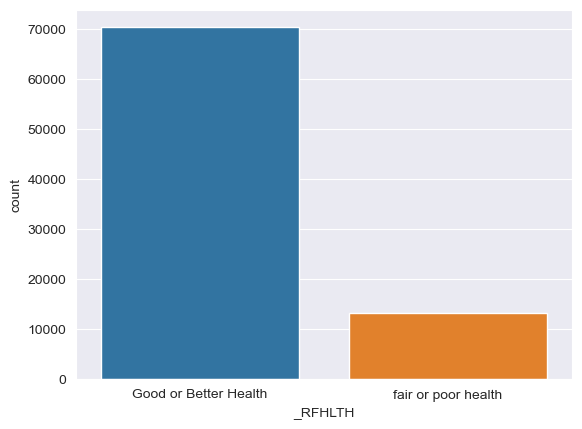

In [7]:
#Balance of the Dataset (TARGET VARIABLE _RFHLTH)
sns.set_style('darkgrid')
sns.countplot(x=model_train['_RFHLTH'])

### Link to Data dictionary
[Data Dictionary](https://github.com/OBINNADINNEYA/MY_BIGDATA_PROJECT/tree/branch_1/Questionnaires%20and%20Calculated%20variables%20(Data%20Dictionary))

We can see that the ratio of those who percieve their health to be good vs those who do not is 7:1 an indication of a highly imbalanced Dataset. We can apply SMOTE technique to introduced randomn samples of the lower class in order to balance out the samples for model training.

In [8]:
# Creating a new data frame with only dummmy categorical data and num columns 
num_cols = list(model_train.select_dtypes(exclude='object').columns)
cat_cols = list(model_train.select_dtypes(include='object').columns)

dummies_df = model_train[num_cols]
cat_cols = list(cat_cols)

for i in ['GENHLTH','_RFHLTH']:
    cat_cols.remove(i)


for i in cat_cols:
    temp = pd.get_dummies(model_train[i], drop_first=True, prefix=i)
    dummies_df = pd.concat([dummies_df, temp.astype(int)], axis=1)

dummies_df.head()

DISPCODE  HHADULT  PHYSHLTH  MENTHLTH  CPDEMO1B  CHILDREN  WEIGHT2  \
0      1200      2.0       0.0       0.0       2.0       3.0    180.0   
1      1200      3.0      20.0       0.0       1.0       0.0    265.0   
2      1200      1.0       1.0       0.0       1.0       0.0    170.0   
3      1100      2.0       0.0       0.0       1.0       4.0    280.0   
4      1100      2.0       0.0       0.0       1.0       0.0    270.0   

   HEIGHT3  _STSTR  _AGE80  ...  STATE_South Carolina  STATE_South Dakota  \
0   1.7780   16049      35  ...                     0                   1   
1   1.8034   16049      42  ...                     0                   1   
2   1.7272   16049      22  ...                     0                   1   
3   1.8288   16039      38  ...                     0                   1   
4   1.9304   16049      72  ...                     0                   1   

   STATE_Tennessee  STATE_Texas  STATE_Utah  STATE_Vermont  STATE_Virginia  \
0                0            0           0              0               0   
1                0            0           0              0               0   
2                0            0           0              0               0   
3                0            0           0              0               0   
4                0            0           0              0               0   

   STATE_Washington  STATE_West Virginia  STATE_Wisconsin  
0                 0                    0                0  
1                 0                    0                0  
2                 0                    0                0  
3                 0                    0                0  
4                 0                    0                0  

[5 rows x 205 columns]

In [9]:
dummies_df.columns = dummies_df.columns.astype(str)
model_train.columns = model_train.columns.astype(str)

In [10]:
#2019 dataset
X = dummies_df
y = model_train['_RFHLTH']

## BASE MODELS

### Base Decision Tree Model

- **Grid Search:** Utilized to fine-tune model hyperparameters ensuring optimal complexity and preventing overfitting.
- **SMOTE Application:** SMOTE is applied exclusively to the training set to address class imbalance, creating synthetic samples to present the model with a balanced class representation during training.
- **Stratified K-Fold Cross-Validation:** Ensures each fold has a representative ratio of the target classes, improving model evaluation and maintaining robustness against class imbalance.

> **Note:** Stratified K-Fold is critical for imbalanced datasets to ensure that performance metrics reflect a model's true predictive power without bias introduced by uneven class distribution across folds.



In [12]:
#1) Base Decision Tree Model

# Splitting the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#SMOTE was included in the pipeline as it has been shown to produce accuracy closer to that in the test accuracy result
pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Parameter grid:
#limiting the max_depth of the tree to prevent overfitting
param_grid = {
    'classifier__max_depth': [None,10, 20],  
    'classifier__min_samples_split': [2, 10], 
    'classifier__min_samples_leaf': [1, 5]  
}

# Cross-validation setup
# Speak to the hyperparameters
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  

# GridSearch setup

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring = 'accuracy',
    cv=stratified_kfold,
    n_jobs=-1
)

# Fitting the model on the training data
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
base_dtree_pipeline = grid_search.best_estimator_


#Retrieve the accuracy for each of the 5 folds of cross-validation
best_params_index = grid_search.best_index_
base_tree_cv_folds_scores = grid_search.cv_results_['split0_test_score'][best_params_index], \
                  grid_search.cv_results_['split1_test_score'][best_params_index], \
                  grid_search.cv_results_['split2_test_score'][best_params_index], \
                  grid_search.cv_results_['split3_test_score'][best_params_index], \
                  grid_search.cv_results_['split4_test_score'][best_params_index]

print(f"Accuracy for each fold using best parameters: {base_tree_cv_folds_scores}")


# Making predictions on the test set
predictions = base_dtree_pipeline.predict(X_test)


# Print classification report and confusion matrix for the test data
print("\nClassification Report (Test Data):\n", classification_report(y_test, predictions))
print('---------------------------------------')
print("Confusion Matrix (Test Data):\n", confusion_matrix(y_test, predictions))


Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best score: 0.867836002001402
Accuracy for each fold using best parameters: (0.8675580787330993, 0.8688279674310898, 0.8661287912744658, 0.8677722994173016, 0.8688928731510533)

Classification Report (Test Data):
                        precision    recall  f1-score   support

Good or Better Health       0.91      0.93      0.92     14038
  fair or poor health       0.60      0.54      0.57      2696

             accuracy                           0.87     16734
            macro avg       0.76      0.74      0.75     16734
         weighted avg       0.86      0.87      0.87     16734

---------------------------------------
Confusion Matrix (Test Data):
 [[13091   947]
 [ 1246  1450]]


-------

In [13]:
#2) Base Logistic Regression 
    #By scaling features before feeding them into a logistic regression model, 
    #you help the model to treat all features fairly, speed up the training process, 
    #and make the output (coefficients) more interpretable.

    # Implementing a pipeline with cross-validation ensures proper scaling practices.
    # Each cross-validation fold scales its data separately, avoiding the mistake of using
    # the entire dataset's information for scaling. This prevents data leakage —
    # a situation where information from outside the training dataset influences the model.
    # Consequently, each validation step is conducted on data scaled within its own fold,
    # maintaining the integrity of the process and leading to a more accurate evaluation
    # of the model's performance.
    
    #Model Pipieline is prepared solely on the training set to avoid data leakage


# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Creating a logistic regression model instance
logreg_model = LogisticRegression(max_iter=1000)

# Creating a pipeline with SMOTE and Logistic Regression:
pipeline = IMBPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE()),
    ('logreg', logreg_model)
])

# Defining the parameter grid
param_grid = {
    'logreg__C': [0.01, 0.1, 1],
    'logreg__solver': ['lbfgs']
}

# GridSearchCV setup
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1)

# Fitting GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and estimator
print("Best Parameters:", grid_search.best_params_)
print(f"Best score: {grid_search.best_score_}")
base_logreg_pipeline = grid_search.best_estimator_


#Retrieve the accuracy for each of the 5 folds of cross-validation
best_params_index = grid_search.best_index_
base_logreg_cv_folds_scores = grid_search.cv_results_['split0_test_score'][best_params_index], \
                  grid_search.cv_results_['split1_test_score'][best_params_index], \
                  grid_search.cv_results_['split2_test_score'][best_params_index], \
                  grid_search.cv_results_['split3_test_score'][best_params_index], \
                  grid_search.cv_results_['split4_test_score'][best_params_index]
print(f"Accuracy for each fold using best parameters: {base_logreg_cv_folds_scores}")

# Predictions and evaluation using the best estimator
y_pred = base_logreg_pipeline.predict(X_test)


print("Classification Report:\n", classification_report(y_test, y_pred))
print('---------------------------------------')
print("Confusion Matrix (Test Data):\n", confusion_matrix(y_test, y_pred))

Best Parameters: {'logreg__C': 1, 'logreg__solver': 'lbfgs'}
Best score: 0.837656101158324
Accuracy for each fold using best parameters: (0.8352132666019273, 0.8419362067677598, 0.83998207082026, 0.8365456447034215, 0.834603316898252)
Classification Report:
                        precision    recall  f1-score   support

Good or Better Health       0.95      0.84      0.89     14038
  fair or poor health       0.49      0.79      0.60      2696

             accuracy                           0.83     16734
            macro avg       0.72      0.81      0.75     16734
         weighted avg       0.88      0.83      0.85     16734

---------------------------------------
Confusion Matrix (Test Data):
 [[11820  2218]
 [  572  2124]]


----

In [14]:
#3) Base Randomn forest Model

# Splitting the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Pipeline with SMOTE and Random Forest classifier
#Model Pipieline is prepared solely on the training set to avoid data leakage

pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', rf_classifier)
])

# Parameter grid for Random Forest classifier including the default parameters, to get the best parameters 
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# StratifiedKFold to maintain the class distribution within each fold for accurate representation of dataset
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning and cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=stratified_kfold,
    n_jobs=-1  
)


# Fitting the model on the training data
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
base_rfc_pipeline = grid_search.best_estimator_


#Retrieve the accuracy for each of the 5 folds of cross-validation
best_params_index = grid_search.best_index_
base_rfc_cv_folds_scores = grid_search.cv_results_['split0_test_score'][best_params_index], \
                  grid_search.cv_results_['split1_test_score'][best_params_index], \
                  grid_search.cv_results_['split2_test_score'][best_params_index], \
                  grid_search.cv_results_['split3_test_score'][best_params_index], \
                  grid_search.cv_results_['split4_test_score'][best_params_index]
print(f"Accuracy for each fold using best parameters: {base_rfc_cv_folds_scores}")

# Making predictions on the test set
predictions = base_rfc_pipeline.predict(X_test)

# Print classification report and confusion matrix for the test data
print("\nClassification Report (Test Data):\n", classification_report(y_test, predictions))
print('---------------------------------------')
print("Confusion Matrix (Test Data):\n", confusion_matrix(y_test, predictions))


Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best score: 0.8883045350264378
Accuracy for each fold using best parameters: (0.8901172779562262, 0.8873534025547173, 0.889137905274167, 0.8855520693261617, 0.8893620200209174)

Classification Report (Test Data):
                        precision    recall  f1-score   support

Good or Better Health       0.91      0.96      0.93     14038
  fair or poor health       0.69      0.51      0.59      2696

             accuracy                           0.88     16734
            macro avg       0.80      0.73      0.76     16734
         weighted avg       0.88      0.88      0.88     16734

---------------------------------------
Confusion Matrix (Test Data):
 [[13437   601]
 [ 1329  1367]]


---

## Models with Feature Selection

We will be using the built in feature selector from the randomn forrest:
    
For our transformation, I've chosen the MinMaxScaler for numeric features and the OrdinalEncoder encoder for categorical features. In the final model, I would most likely OneHotEncode (OHE) for the categorical features, but to determine feature importance, we don't want to expand the columns with OHE; we'll get more value out of treating them as one column with ordinal encoded values.

In [15]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline

In [16]:
# Using 2019 datasets #1 split the data
X = model_train.drop(columns=['_RFHLTH','GENHLTH'])
y = model_train['_RFHLTH']

#1 Split the data into 20% test and 80% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [17]:
column_trans = ColumnTransformer(transformers=
        [('num', MinMaxScaler(), selector(dtype_exclude="object")),
        ('cat', OrdinalEncoder(), selector(dtype_include="object"))],
        remainder='drop')

In [18]:
#Create a random forest classifier for feature importance
#Class weight parameter is set to balanced because this is an unbalanced dataset

clf = RandomForestClassifier(random_state=42, n_jobs=6, class_weight='balanced')

pipeline = Pipeline([('prep',column_trans),
                     ('clf', clf)])

In [19]:
#2 fit the pipeline to training set only to avoid data leakage
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16e6ba710>),
                                                 ('cat', OrdinalEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16e6b98d0>)])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=6,
                                        random_state=42))])

In [20]:
feat_list = []

targets = list(X.columns)

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(targets, pipeline['clf'].feature_importances_):
    feat_list.append(feature)
    total_importance += feature[1]

included_feats = []
# Print the name and gini importance of each feature
for feature in zip(targets, pipeline['clf'].feature_importances_):
    if feature[1] > .008:
        included_feats.append(feature[0])

print('\n',"Cumulative Importance =", total_importance)

# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()


 Cumulative Importance = 0.9999999999999998


In [21]:
pd.set_option('display.max_columns', None)

In [22]:
df_imp

FEATURE  IMPORTANCE    CUMSUM
2     SEXVAR    0.110991  0.110991
66  _RFSMOK3    0.090577  0.201568
56  _AGE65YR    0.042935  0.244503
11   ASTHMA3    0.028459  0.272962
3   PHYSHLTH    0.025639  0.298602
..       ...         ...       ...
20  CPDEMO1B    0.000574  0.998799
22   EMPLOY1    0.000548  0.999347
30  DIFFDRES    0.000494  0.999841
29  DIFFWALK    0.000100  0.999941
28    DECIDE    0.000059  1.000000

[95 rows x 3 columns]

In [23]:
print('Most Important Features:')
print(included_feats)
print('Number of Included Features =', len(included_feats))

Most Important Features:
['SEXVAR', 'PHYSHLTH', 'MEDCOST1', 'CHECKUP1', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3', 'CHCOCNCR', 'ADDEPEV3', 'CHCKDNY2', 'DIABETE4', 'MARITAL', 'EDUCA', 'RENTHOM1', 'WEIGHT2', 'HEIGHT3', 'SMOKE100', 'USENOW3', 'EXERANY2', '_ASTHMS1', '_MRACE1', '_RACEG21', '_AGEG5YR', '_AGE65YR', '_AGE_G', '_BMI5CAT', '_RFSMOK3', 'DRNKANY5', '_RFBING5', '_VEGRES1', '_VEGESU1', '_FRT16A', '_VEG23A', '_MMSAWT', 'DROCDY3_']
Number of Included Features = 36


In [24]:
#Creating a new data frame with only dummmy categorical data and num columns from selected feature list
num_cols = list(model_train[included_feats].select_dtypes(exclude='object').columns)
cat_cols = list(model_train[included_feats].select_dtypes(include='object').columns)

dummies_df2 = model_train[num_cols]
cat_cols = list(cat_cols)

for i in cat_cols:
    temp = pd.get_dummies(model_train[i], drop_first=True, prefix=i)
    dummies_df2 = pd.concat([dummies_df2, temp.astype(int)], axis=1)

dummies_df2.head()

PHYSHLTH  WEIGHT2  HEIGHT3  DRNKANY5  _VEGRES1  _VEGESU1  _FRT16A  _VEG23A  \
0       0.0    180.0   1.7780         1         1      1.43        1        1   
1      20.0    265.0   1.8034         1         1      1.72        1        1   
2       1.0    170.0   1.7272         1         1      1.24        1        1   
3       0.0    280.0   1.8288         1         1      2.14        1        1   
4       0.0    270.0   1.9304         1         1      4.71        1        1   

      _MMSAWT  DROCDY3_  SEXVAR_male  MEDCOST1_yes  CHECKUP1_2 years  \
0  147.703815  0.285714            1             0                 0   
1   81.705709  0.233333            1             0                 0   
2   88.929326  0.133333            1             1                 0   
3    7.414992  0.100000            1             0                 0   
4   20.331805  0.142857            1             0                 0   

   CHECKUP1_5 years  CHECKUP1_>5 years  CHECKUP1_never  CHECKUP1_unknown  \
0                 0                  0               0                 0   
1                 1                  0               0                 0   
2                 1                  0               0                 0   
3                 1                  0               0                 0   
4                 0                  0               0                 0   

   CVDINFR4_yes  CVDCRHD4_yes  CVDSTRK3_yes  ASTHMA3_yes  CHCOCNCR_yes  \
0             0             0             0            0             0   
1             0             0             0            0             0   
2             0             0             0            0             0   
3             0             0             0            0             0   
4             0             0             0            0             0   

   ADDEPEV3_yes  CHCKDNY2_yes  DIABETE4_yes  MARITAL_living together  \
0             0             0             0                        0   
1             0             0             1                        0   
2             0             0             0                        0   
3             0             0             0                        0   
4             0             0             0                        0   

   MARITAL_married  MARITAL_separated  MARITAL_single  MARITAL_widowed  \
0                1                  0               0                0   
1                1                  0               0                0   
2                0                  0               1                0   
3                1                  0               0                0   
4                1                  0               0                0   

   EDUCA_12/ged  EDUCA_9-11  EDUCA_c1-3  EDUCA_cg  EDUCA_none  RENTHOM1_own  \
0             0           0           1         0           0             1   
1             0           0           0         1           0             1   
2             0           0           0         1           0             0   
3             0           0           0         1           0             1   
4             0           0           0         1           0             1   

   RENTHOM1_rent  SMOKE100_yes  USENOW3_never  USENOW3_somedays  EXERANY2_yes  \
0              0             1              1                 0             1   
1              0             0              0                 1             1   
2              1             0              1                 0             1   
3              0             0              1                 0             1   
4              0             1              1                 0             0   

   _ASTHMS1_current  _ASTHMS1_former  _MRACE1_blackonly  _MRACE1_multiracial  \
0                 0                0                  0                    0   
1                 0                0                  0                    0   
2                 0                0                  0                    0   
3                 0  

In [25]:
#Obtaining the selected columns and the target column
X = dummies_df2
y = model_train['_RFHLTH'] #target variable (percieved good health vs percieved bad/fair health)

In [26]:
#1) Decision Tree Model With Selected features

# Splitting the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#SMOTE was included in the pipeline as it has been shown to produce accuracy closer to that
#in the test accuracy result
#Model Pipieline is prepared solely on the training set to avoid data leakage
pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Parameter grid:
#limiting the max_depth of the tree to prevent overfitting
param_grid = {
    'classifier__max_depth': [None,10, 20],  
    'classifier__min_samples_split': [2, 10], 
    'classifier__min_samples_leaf': [1, 5]  
}

# Cross-validation setup
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  

# GridSearch setup using accuracy as our metric and inputing the stratified cross validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy', 
    cv=stratified_kfold,
    n_jobs=-1
)

# Fitting the model on the training data
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
dtree_pipeline = grid_search.best_estimator_

#Retrieve the accuracy for each fold of cross-validation
best_params_index = grid_search.best_index_
dtree_cv_folds_scores = grid_search.cv_results_['split0_test_score'][best_params_index], \
                  grid_search.cv_results_['split1_test_score'][best_params_index], \
                  grid_search.cv_results_['split2_test_score'][best_params_index], \
                  grid_search.cv_results_['split3_test_score'][best_params_index], \
                  grid_search.cv_results_['split4_test_score'][best_params_index]
print(f"Accuracy for each fold using best parameters: {dtree_cv_folds_scores}")

# Making predictions on the test set
predictions = dtree_pipeline.predict(X_test)

# Print classification report and confusion matrix for the test data
print("\nClassification Report (Test Data):\n", classification_report(y_test, predictions))
print('---------------------------------------')
print("Confusion Matrix (Test Data):\n", confusion_matrix(y_test, predictions))


Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}
Best score: 0.8601117469911085
Accuracy for each fold using best parameters: (0.8616568312542018, 0.8591170538582207, 0.8608994471836247, 0.8615717914238757, 0.8573136112356193)

Classification Report (Test Data):
                        precision    recall  f1-score   support

Good or Better Health       0.91      0.92      0.92     14038
  fair or poor health       0.57      0.53      0.55      2696

             accuracy                           0.86     16734
            macro avg       0.74      0.73      0.73     16734
         weighted avg       0.86      0.86      0.86     16734

---------------------------------------
Confusion Matrix (Test Data):
 [[12938  1100]
 [ 1266  1430]]


In [27]:
#2) Logistic Regression with Selected features

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Creating a logistic regression model instance
logreg_model = LogisticRegression(max_iter=1000)

# Creating a pipeline with StandardScaler, SMOTE, and Logistic Regression:
#NB: see Note above on scaling and inputing smote and scaler in pipeline before CV to avoid overfitting and data
#leakage
#Model Pipieline is prepared solely on the training set to avoid data leakage

pipeline = IMBPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('logreg', logreg_model)
])

# Defining the parameter grid to compare parameters for estimators
param_grid = {
    'logreg__C': [0.01, 0.1, 1],
    'logreg__solver': ['lbfgs']
}

# GridSearchCV setup
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fitting GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and estimator
print("Best Parameters:", grid_search.best_params_)
logreg_pipeline = grid_search.best_estimator_



#Retrieve the accuracy for each fold of cross-validation
best_params_index = grid_search.best_index_
logreg_cv_folds_scores = grid_search.cv_results_['split0_test_score'][best_params_index], \
                  grid_search.cv_results_['split1_test_score'][best_params_index], \
                  grid_search.cv_results_['split2_test_score'][best_params_index], \
                  grid_search.cv_results_['split3_test_score'][best_params_index], \
                  grid_search.cv_results_['split4_test_score'][best_params_index]
print(f"Accuracy for each fold using best parameters: {logreg_cv_folds_scores}")

# Predictions and evaluation using the best estimator
y_pred = logreg_pipeline.predict(X_test)


print("Classification Report:\n", classification_report(y_test, y_pred))
print('---------------------------------------')
print("Confusion Matrix (Test Data):\n", confusion_matrix(y_test, y_pred))


Best Parameters: {'logreg__C': 0.1, 'logreg__solver': 'lbfgs'}
Accuracy for each fold using best parameters: (0.8316276985134833, 0.8383506386793158, 0.837143284028089, 0.8348274316450023, 0.8396832511579262)
Classification Report:
                        precision    recall  f1-score   support

Good or Better Health       0.95      0.84      0.89     14038
  fair or poor health       0.49      0.77      0.59      2696

             accuracy                           0.83     16734
            macro avg       0.72      0.81      0.74     16734
         weighted avg       0.87      0.83      0.85     16734

---------------------------------------
Confusion Matrix (Test Data):
 [[11854  2184]
 [  631  2065]]


In [28]:
#3) Randomn forrest Model with Selected features

# Splitting the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Pipeline with SMOTE and Random Forest classifier
pipeline = IMBPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', rf_classifier)
])

# Parameter grid for Random Forest classifier including the default parameters, to get the best parameters 
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# StratifiedKFold to maintain the class distribution within each fold for accurate representation of dataset
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning and cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=stratified_kfold,
    n_jobs=-1  
)


# Fitting the model on the training data Only to avoid any data leakage
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
rfc_pipeline = grid_search.best_estimator_

#Retrieve the accuracy for each fold of cross-validation
best_params_index = grid_search.best_index_
rfc_cv_folds_scores = grid_search.cv_results_['split0_test_score'][best_params_index], \
                  grid_search.cv_results_['split1_test_score'][best_params_index], \
                  grid_search.cv_results_['split2_test_score'][best_params_index], \
                  grid_search.cv_results_['split3_test_score'][best_params_index], \
                  grid_search.cv_results_['split4_test_score'][best_params_index]
print(f"Accuracy for each fold using best parameters: {rfc_cv_folds_scores}")

# Making predictions on the test set
predictions = rfc_pipeline.predict(X_test)

# Print classification report and confusion matrix for the test data
print("\nClassification Report (Test Data):\n", classification_report(y_test, predictions))
print('---------------------------------------')
print("Confusion Matrix (Test Data):\n", confusion_matrix(y_test, predictions))


Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best score: 0.8810733291107505
Accuracy for each fold using best parameters: (0.8819750504220513, 0.8801075670426534, 0.8823397579560736, 0.8797997908262364, 0.8811444793067383)

Classification Report (Test Data):
                        precision    recall  f1-score   support

Good or Better Health       0.91      0.95      0.93     14038
  fair or poor health       0.67      0.48      0.56      2696

             accuracy                           0.88     16734
            macro avg       0.79      0.72      0.75     16734
         weighted avg       0.87      0.88      0.87     16734

---------------------------------------
Confusion Matrix (Test Data):
 [[13384   654]
 [ 1390  1306]]


---

### WILCOXON RANKED SIGN STATISTICAL TEST

In [32]:
#Each test will be between the baseline and feature-selected model of the same type 

# Perform the Wilcoxon signed-rank test
dtree_wilcoxon = wilcoxon(base_tree_cv_folds_scores, dtree_cv_folds_scores)
rfc_wilcoxon = wilcoxon(base_rfc_cv_folds_scores, rfc_cv_folds_scores)
logreg_wilcoxon = wilcoxon(base_logreg_cv_folds_scores, logreg_cv_folds_scores)

# Print the test statistics and p-values
print('Decision Tree Wilcoxon Test:', dtree_wilcoxon)
print('Random Forest Wilcoxon Test:', rfc_wilcoxon)
print('Logistic Regression Wilcoxon Test:', logreg_wilcoxon)


Decision Tree Wilcoxon Test: WilcoxonResult(statistic=0.0, pvalue=0.0625)
Random Forest Wilcoxon Test: WilcoxonResult(statistic=0.0, pvalue=0.0625)
Logistic Regression Wilcoxon Test: WilcoxonResult(statistic=5.0, pvalue=0.625)


### Analysis of the Wilcoxon Signed-Rank Test

For the comparison of baseline models versus feature-selected models, the Wilcoxon signed-rank test was employed for each pair due to the non-parametric nature of the data and the small sample size of the cross-validation folds.

#### Hypotheses:

- **Null Hypotheses (H₀)**:
  1. There is no difference in the mean ranks of accuracy scores between the baseline Decision Tree and the feature-selected Decision Tree.
  2. There is no difference in the mean ranks of accuracy scores between the baseline Random Forest and the feature-selected Random Forest.
  3. There is no difference in the mean ranks of accuracy scores between the baseline Logistic Regression and the feature-selected Logistic Regression.

- **Alternative Hypotheses (H₁)**:
  1. There is a difference in the mean ranks of accuracy scores between the baseline Decision Tree and the feature-selected Decision Tree.
  2. There is a difference in the mean ranks of accuracy scores between the baseline Random Forest and the feature-selected Random Forest.
  3. There is a difference in the mean ranks of accuracy scores between the baseline Logistic Regression and the feature-selected Logistic Regression.

#### Confidence Interval: 95%

#### Test Results:

- **Decision Tree Comparison**:
  - p-value = 0.0625
  - Since the p-value is greater than 0.05, we fail to reject the null hypothesis. This suggests that there is not a statistically significant difference in mean ranks of accuracy scores between the baseline and feature-selected Decision Tree at the 95% confidence level.

- **Random Forest Comparison**:
  - p-value = 0.0625
  - As with the Decision Tree comparison, the p-value is greater than 0.05, leading us to fail to reject the null hypothesis. There is not a statistically significant difference in mean ranks of accuracy scores between the baseline and feature-selected Random Forest at the 95% confidence level.

- **Logistic Regression Comparison**:
  - p-value = 0.625
  - The p-value greatly exceeds the 0.05 threshold, indicating a strong likelihood that we fail to reject the null hypothesis. There is no statistically significant difference in mean ranks of accuracy scores between the baseline and feature-selected Logistic Regression models.

Based on these results, none of the feature-selected models demonstrated a statistically significant improvement over the baseline models in terms of accuracy scores using the Wilcoxon signed-rank test at the 95% confidence level.


---

### SELECTION OF THE BEST MODEL FOR VALIDATION ON THE 2021 DATASET

In [ ]:
#Note Dta leakage was avoided by using two seprate datasets for 
#training and evaluation of models before validating selected model

import joblib

# Save the best_pipeline to disk
filename = 'finalized_model.sav'
joblib.dump(#pipelinename, filename)

# Load the model from disk later to make new predictions
loaded_model = joblib.load(filename)
new_data = # new data to predict in expected shape depending on the model
new_predictions = loaded_model.predict(new_data)


# Assuming X_2021 and y_2021 are your 2021 dataset
# test_score = roc_auc_score(y_2021, grid_search.predict(X_2021))
# print(f'Test score on 2021 data: {test_score}')

In [ ]:
####Conclusion

# Reducing False Negatives in Health Predictions: A Crucial Goal

**Ensuring Patient Safety**: Avoiding missed diagnoses that could lead to worsened health or preventable deaths is paramount for patient safety.

**Facilitating Early Intervention**: Accurate identification of poor health allows for timely intervention, often resulting in better health outcomes.

**Lowering Healthcare Costs**: Early detection of health issues can prevent the need for more complex and expensive treatments later on.

**Improving Public Health**: Correct health status predictions are vital for efficient public health planning and resource allocation.

**Prioritizing Healthcare Needs**: With finite resources, identifying at-risk individuals ensures that care is directed where it's most needed, such as during health crises.

**Encouraging Treatment Adherence**: Patients who understand their health risks are more likely to follow treatment plans.

**Maintaining Trust**: Accurate predictions reinforce trust in the healthcare system, crucial for public cooperation in health programs.

In short, minimizing false negatives is essential for a trustworthy, cost-effective, and proactive healthcare system that truly serves its patients.
